## Embedding viz

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

  import numpy.matlib as npm

  autumn = cm.get_cmap('autumn', 256)

  winter = cm.get_cmap('winter_r', 256)



In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


Resorting genes by reference genome order
Resorting genes by reference genome order


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 58.2%
RAM Usage: 12.8%
Available RAM: 328.8G
Total RAM: 377.1G
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


0
Available GPUs: 1
GPU 0: Quadro RTX 8000 - Memory Allocated: 0.00 GB


### Setup

In [6]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

from data.data_viz import plot_umap_embeddings_w_fc

In [7]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_umap_embeddings_w_fc

### SMT POOL EMBEDDINGS ###
from models.smt import SharedSelfAttentionPoolingModel, SharedSelfAttentionCLSPoolingModel

# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

### PCA ###
X_pca = load_transcriptome(parcellation='S456', run_PCA='95var', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X_valid = X[valid_indices]
X_pca = X_pca[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

Loading data...
Resorting genes by reference genome order
Resorting genes by reference genome order
Number of components for 95% variance PCA: 27


### Brain montage

In [8]:
os.environ["NILEARN_DATA"] = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/nilearn_data"
from brainmontage import brainmontage
from brainmontage import create_montage_figure, save_image
from nilearn import datasets as nldatasets
import matplotlib.colors as mcolors


# Patch just the fetch_surf_fsaverage call to set data_dir properly
_original_fetch_surf = nldatasets.fetch_surf_fsaverage

def _patched_fetch_surf_fsaverage(*args, **kwargs):
    kwargs['data_dir'] = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/nilearn_data"
    return _original_fetch_surf(*args, **kwargs)

nldatasets.fetch_surf_fsaverage = _patched_fetch_surf_fsaverage

In [9]:
network_colors = {
        'Frontoparietal (FPN)': '#D68E63',  # Darker Orange
        'Default mode (DMN)': '#D67A7A',     # Darker Red
        'Salience (SN)': '#55B755',          # Darker Green
        'Limbic (LN)': '#D6CC7A',            # Darker Yellow
        'Dorsal attention (DAN)': '#D67AD6',  # Darker Magenta
        'Somatosensory motor (SMN)': '#639CD6', # Darker Light Blue
        'Visual (VN)': '#7B3B7B'             # Darker Purple   
    }

cortical_network_labels = network_labels[:400]

Plot functional subnetwork on brain

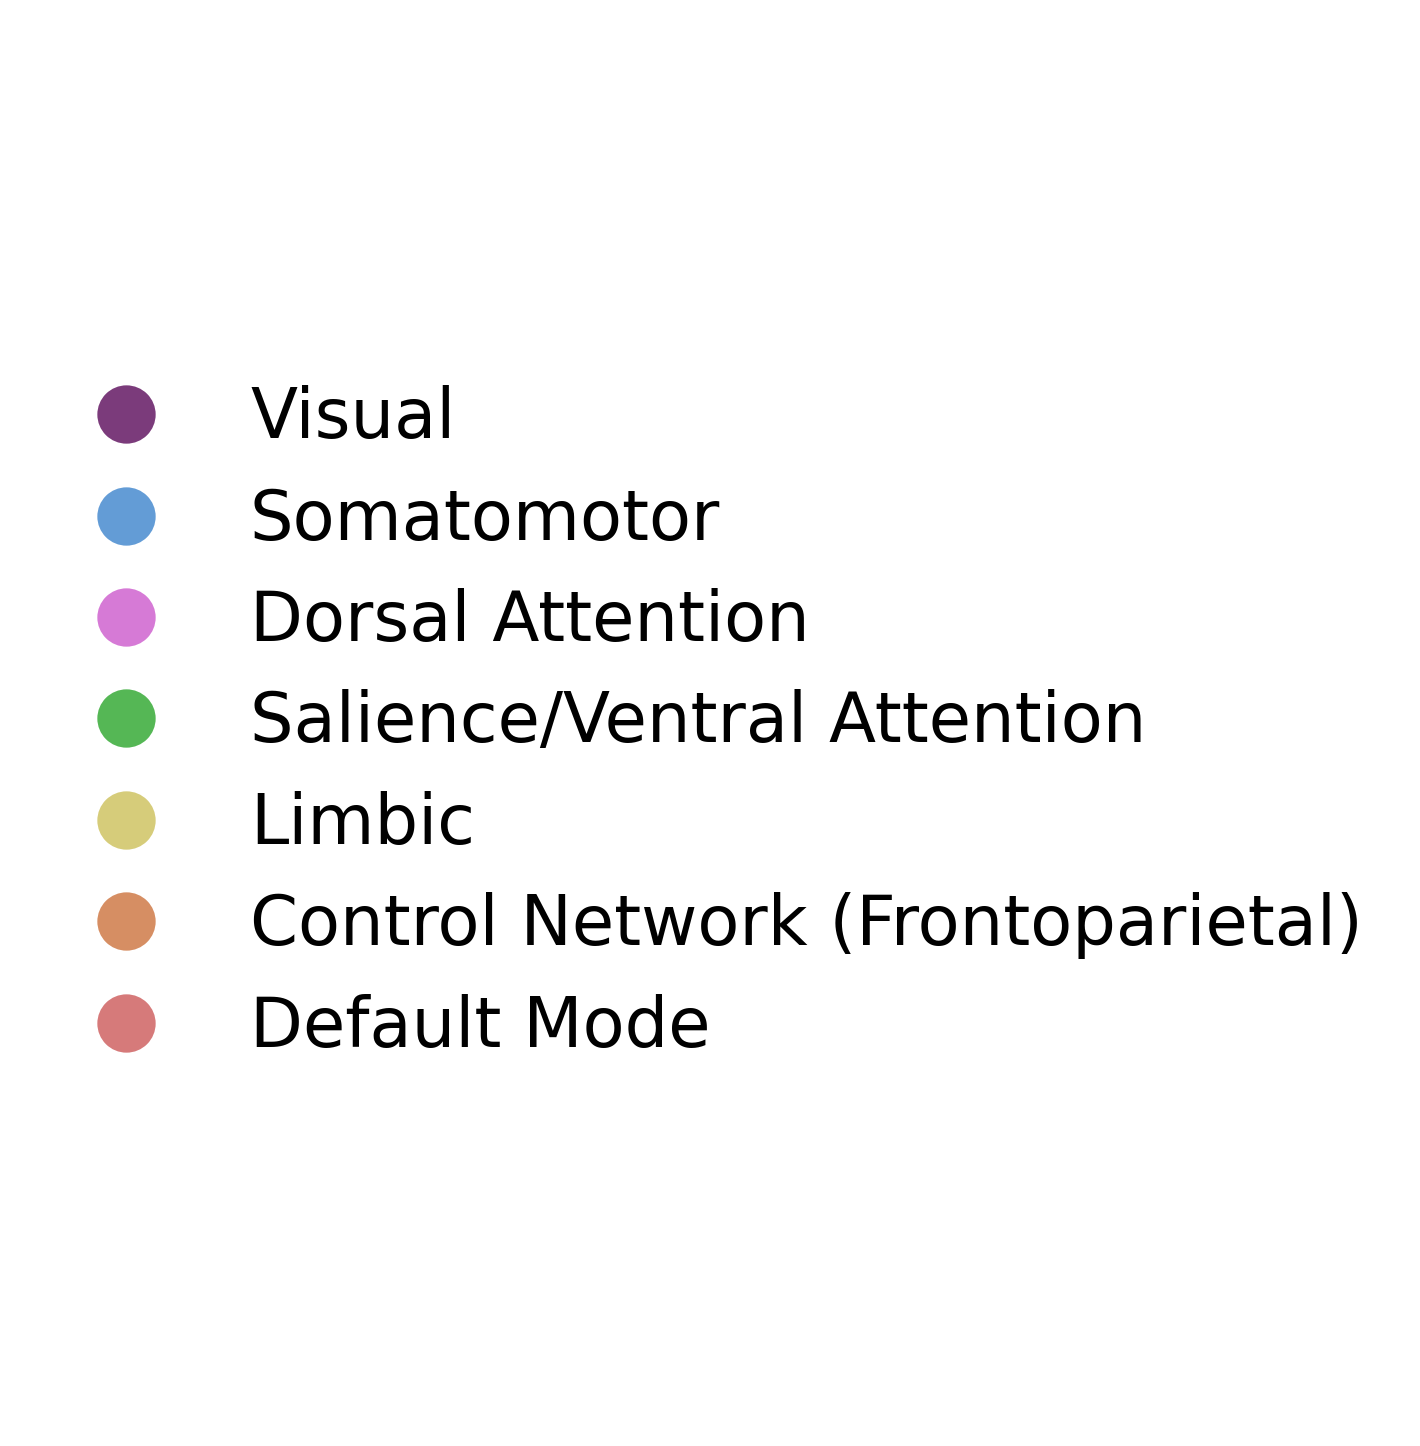

In [10]:
from matplotlib.lines import Line2D

# Map network label to RGB color
network_to_color = {
    'Vis': '#7B3B7B',
    'SomMot': '#639CD6',
    'DorsAttn': '#D67AD6',
    'SalVentAttn': '#55B755',
    'Limbic': '#D6CC7A',
    'Cont': '#D68E63',
    'Default': '#D67A7A',
    'Subcortical': '#000080',  # Dark blue
    'Cerebellum': '#006400'  # Dark green
}

# Convert labels to RGB triplets for each ROI
cortical_roi_vals = np.array([
    mcolors.to_rgb(network_to_color.get(label, "#BBBBBB"))  # fallback to gray
    for label in cortical_network_labels
])  # shape (400, 3)

roivals = np.array([
    mcolors.to_rgb(network_to_color.get(label, "#BBBBBB"))  # fallback to gray
    for label in network_labels
])  # shape (455, 3)

# Create legend handles and matching labels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['Vis'],
           label='Visual', markersize=15),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['SomMot'],
           label='Somatomotor', markersize=15),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['DorsAttn'],
           label='Dorsal Attention', markersize=15),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['SalVentAttn'],
           label='Salience/Ventral Attention', markersize=15),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['Limbic'],
           label='Limbic', markersize=15),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['Cont'],
           label='Control Network (Frontoparietal)', markersize=15),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['Default'],
           label='Default Mode', markersize=15)
    # Subcortical and Cerebellum not shown; uncomment below to add.
    # Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['Subcortical'],
    #        label='Subcortical', markersize=15),
    # Line2D([0], [0], marker='o', color='w', markerfacecolor=network_to_color['Cerebellum'],
    #        label='Cerebellum', markersize=15)
]

legend_labels = [handle.get_label() for handle in legend_elements]

# Create a separate figure for the legend
fig = plt.figure(figsize=(3, 6), dpi=300)
ax = fig.add_subplot(111)
ax.legend(handles=legend_elements, labels=legend_labels, loc='center', frameon=False)
ax.axis('off')
plt.show()


In [11]:
cortical_roi_vals

array([[0.48235294, 0.23137255, 0.48235294],
       [0.48235294, 0.23137255, 0.48235294],
       [0.48235294, 0.23137255, 0.48235294],
       ...,
       [0.83921569, 0.47843137, 0.47843137],
       [0.83921569, 0.47843137, 0.47843137],
       [0.83921569, 0.47843137, 0.47843137]])

For cmapfile=lut, override input values and clim to display LUT colormap: /ext3/miniconda3/lib/python3.11/site-packages/brainmontage/atlases/schaefer400_7Networks_LUT.txt.


  warn(

  warn(



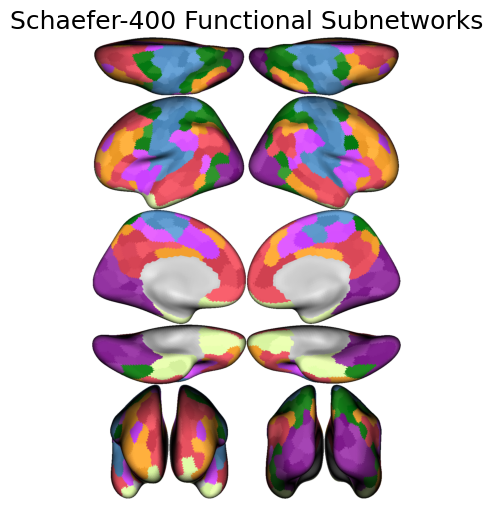

In [12]:
img = create_montage_figure(
    roivals=cortical_roi_vals,
    atlasname='schaefer400',
    viewnames='all',
    surftype='infl',
    hemis='both',
    colormap='lut',
    no_lookup=True,
    #noshading=True,
    backgroundcolor='white',
    upscale_factor=2,
    face_mode='best'
)

save_image(img,'schaefer400_cortical_networks.png')

# === Step 4: Show it inline === #
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Schaefer-400 Functional Subnetworks")
plt.show()

Plot gene expression PC1 on brain

In [14]:
gene_pc_vals = X_pca[:, 1]  # PC1 scores for each parcel


  warn(

  warn(



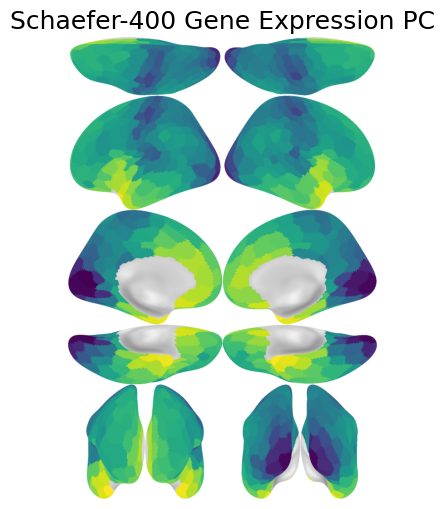

In [15]:
# Visualize PC1 scores on the cortex using viridis colormap
img = create_montage_figure(
    roivals=gene_pc_vals,
    atlasname='schaefer400',
    viewnames='all',
    surftype='infl',
    hemis='both',
    colormap='viridis_r',
    no_lookup=True,
    noshading=True,
    backgroundcolor='white',
    upscale_factor=3,
    face_mode='best'
)

save_image(img, 'schaefer400_gene_PC2.png')

# Show it inline
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Schaefer-400 Gene Expression PC")
plt.show()

Plot functional connectivity PC1 on brain

In [16]:
from sklearn.decomposition import PCA

Y_pca = PCA(n_components=5).fit_transform(Y)  # shape (n_parcels, 1)
fc_pc1_vals = Y_pca[:, 1]  # PO/PC1 scores for each parcel

  warn(

  warn(



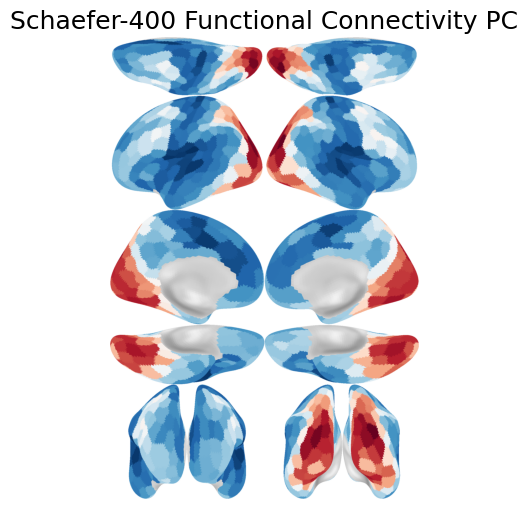

In [17]:
# Visualize PC1 scores on the cortex using viridis colormap
img = create_montage_figure(
    roivals=fc_pc1_vals,
    atlasname='schaefer400',
    viewnames='all',
    surftype='infl',
    hemis='both',
    colormap='RdBu_r',
    no_lookup=True,
    noshading=True,
    backgroundcolor='white',
    upscale_factor=3,
    face_mode='best'
)

save_image(img, 'schaefer400_fc_PC1.png')

# Show it inline
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Schaefer-400 Functional Connectivity PC")
plt.show()

Non-linear gain

In [ ]:
# Per subnetwork SMT > Bilinear gains
mean_gains = {
    'Vis': 0.088,
    'SomMot': 0.081, 
    'DorsAttn': 0.063,
    'SalVentAttn': 0.061,
    'Limbic': 0.044,
    'Cont': 0.054,
    'Default': 0.047,
    'Subcortical': 0.036,
    'Cerebellum': 0.058
}

intra_network_gains = {
    'Vis': 0.11,
    'SomMot': 0.11,
    'DorsAttn': 0.071,
    'SalVentAttn': 0.069,
    'Limbic': 0.035,
    'Cont': 0.057,
    'Default': 0.040,
    'Subcortical': 0.032,
    'Cerebellum': 0.035
}

inter_network_gains = {
    'Vis': 0.069,
    'SomMot': 0.056,
    'DorsAttn': 0.055,
    'SalVentAttn': 0.054,
    'Limbic': 0.054,
    'Cont': 0.051,
    'Default': 0.055,
    'Subcortical': 0.041,
    'Cerebellum': 0.082
}


In [38]:
# Create array mapping each ROI to its network's gain value
mean_gain_vals = np.zeros_like(cortical_network_labels)
intra_gain_vals = np.zeros_like(cortical_network_labels) 
inter_gain_vals = np.zeros_like(cortical_network_labels)

for network, gain in mean_gains.items():
    mean_gain_vals[cortical_network_labels == network] = gain
    
for network, gain in intra_network_gains.items():
    intra_gain_vals[cortical_network_labels == network] = gain
    
for network, gain in inter_network_gains.items():
    inter_gain_vals[cortical_network_labels == network] = gain


  warn(



  warn(



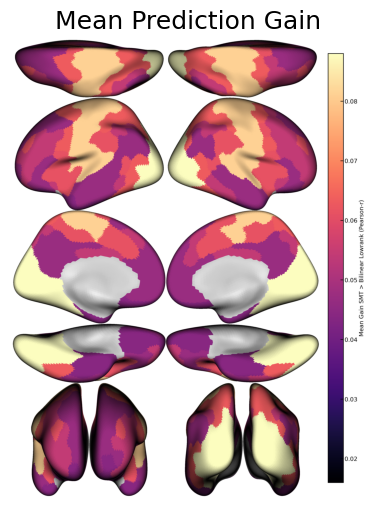

In [41]:

# Plot mean gains
img1 = create_montage_figure(
    roivals=mean_gain_vals,
    atlasname='schaefer400',
    viewnames='all', 
    surftype='infl',
    hemis='both',
    no_lookup=True,
    backgroundcolor='white',
    colormap='magma',
    clim=[min(mean_gains.values())-0.02, max(mean_gains.values())],
    upscale_factor=5,
    face_mode='best',
    add_colorbar=True,
    colorbar_label='Mean Gain SMT > Bilinear Lowrank (Pearson-r)'
)

save_image(img1,'schaefer400_mean_gain.png')

plt.figure(figsize=(6, 6))
plt.imshow(img1)
plt.axis('off')
plt.title("Mean Prediction Gain")
plt.show()

  warn(

  warn(



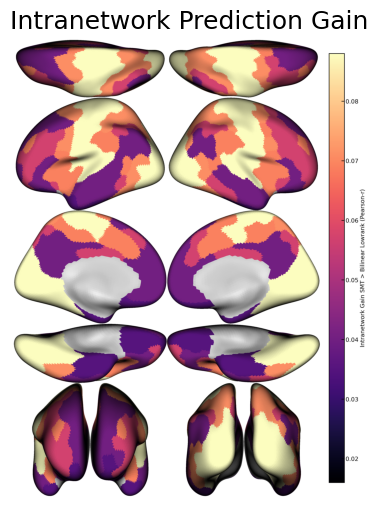

In [42]:

# Plot mean gains
img2 = create_montage_figure(
    roivals=intra_gain_vals,
    atlasname='schaefer400',
    viewnames='all', 
    surftype='infl',
    hemis='both',
    no_lookup=True,
    backgroundcolor='white',
    colormap='magma',
    clim=[min(mean_gains.values())-0.02, max(mean_gains.values())],
    upscale_factor=5,
    face_mode='best',
    add_colorbar=True,
    colorbar_label='Intranetwork Gain SMT > Bilinear Lowrank (Pearson-r)'
)

save_image(img2,'schaefer400_intra_gain.png')

plt.figure(figsize=(6, 6))
plt.imshow(img2)
plt.axis('off')
plt.title("Intranetwork Prediction Gain")
plt.show()

  warn(

  warn(



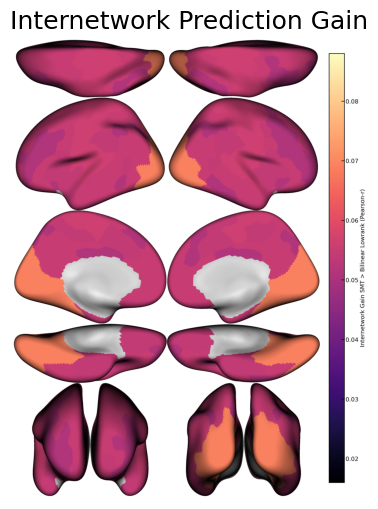

In [45]:

# Plot mean gains
img3 = create_montage_figure(
    roivals=inter_gain_vals,
    atlasname='schaefer400',
    viewnames='all', 
    surftype='infl',
    hemis='both',
    no_lookup=True,
    backgroundcolor='white',
    colormap='magma',
    clim=[min(mean_gains.values())-0.02, max(mean_gains.values())],
    upscale_factor=5,
    face_mode='best',
    add_colorbar=True,
    colorbar_label='Internetwork Gain SMT > Bilinear Lowrank (Pearson-r)'
)

save_image(img3,'schaefer400_inter_gain.png')

plt.figure(figsize=(6, 6))
plt.imshow(img3)
plt.axis('off')
plt.title("Internetwork Prediction Gain")
plt.show()